# ロジスティクス回帰による予測（Day2）

## 前回（Day1）の予測精度
・正答率 = 61.257%  
・適合率（Precision） = 61.683%  
・再現率（Recall） = 92.413%  
・F1値（F1-score） = 73.984%

## 今回の課題
・各特徴量をグラフ化し、異常値の確認を行う  
・交差検証、ホールドアウト法による汎化性能確認   
・Day1時の精度と比較する  
・交差検証によるパラメータチューニングを行う  
・ニューニング後のモデルによって、精度および結果の評価を行う

## Day1の内容（再掲）

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数

In [2]:
#csvファイルの読み込み（生データks_raw）
df_raw = pd.read_csv('../task/ks-projects-201801.csv')
#最初の5行を表示
display(df_raw.head())
#
df_raw.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


## 使用する説明変数
①deadlineからlaunchを引いた期間(period)を追加  
②以下を削除  
　　・関係のなさそうな変数を削除：ID, name, deadline, launched    
　　・事前予測に使用できない変数を削除：pledged, backers, usd pledged,　usd_pledged_real  
　　・単位の統一されているusd_goal_realを採用するため、goalを削除  
　  　・categoryは細かいので、main_categoryで対処する

**①の実行**

In [3]:
#datetime型に変換（launchedは時刻部分を削除）
df_raw['deadline'] = pd.to_datetime(df_raw['deadline'])
df_raw['launched'] = pd.to_datetime(pd.to_datetime(df_raw['launched']).dt.date) #.dt.dateで日付まで表記（時刻削除）

#差を期間とする
df_raw['period'] = (df_raw['deadline'] - df_raw['launched']).dt.days

**②の実行**

In [4]:
#csvファイルを読み込み、上記を削除
df = df_raw[['main_category','currency','state','country','usd_goal_real','period']]
#削除できているか、period追加されているか確認
display(df.head())

,main_category,currency,state,country,usd_goal_real,period
0,Publishing,GBP,failed,GB,1533.95,59
1,Film & Video,USD,failed,US,30000.00,60
2,Film & Video,USD,failed,US,45000.00,45
3,Music,USD,failed,US,5000.00,30
4,Film & Video,USD,canceled,US,19500.00,56


## 目的変数をダミー変数へ変更

In [5]:
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [6]:
#failed,successful以外は結果がわからないので、削除
df = df.query('state == ["failed","successful"]')
#successfulを1、failedを0に変換
df.loc[df['state']=='successful','state']=1
df.loc[df['state']=='failed','state']=0
#削除できているか確認
df['state'].value_counts()

0    197719
1    133956
Name: state, dtype: int64

## 説明変数の精査

**グラフ確認してみる（Day1同様）**

In [7]:
#カテゴリ変数をエンコード
oe = OrdinalEncoder()
df[['main_category','currency','country','state']] = oe.fit_transform(df[['main_category','currency','country','state']])
#できているか確認
df.head()

,main_category,currency,state,country,usd_goal_real,period
0,12.0,5.0,0.0,9.0,1533.95,59
1,6.0,13.0,0.0,22.0,30000.00,60
2,6.0,13.0,0.0,22.0,45000.00,45
3,10.0,13.0,0.0,22.0,5000.00,30
5,7.0,13.0,1.0,22.0,50000.00,35


In [8]:
df.dtypes

main_category    float64
currency         float64
state            float64
country          float64
usd_goal_real    float64
period             int64
dtype: object

In [9]:
#欠損値確認
df.isnull().sum()

main_category    0
currency         0
state            0
country          0
usd_goal_real    0
period           0
dtype: int64

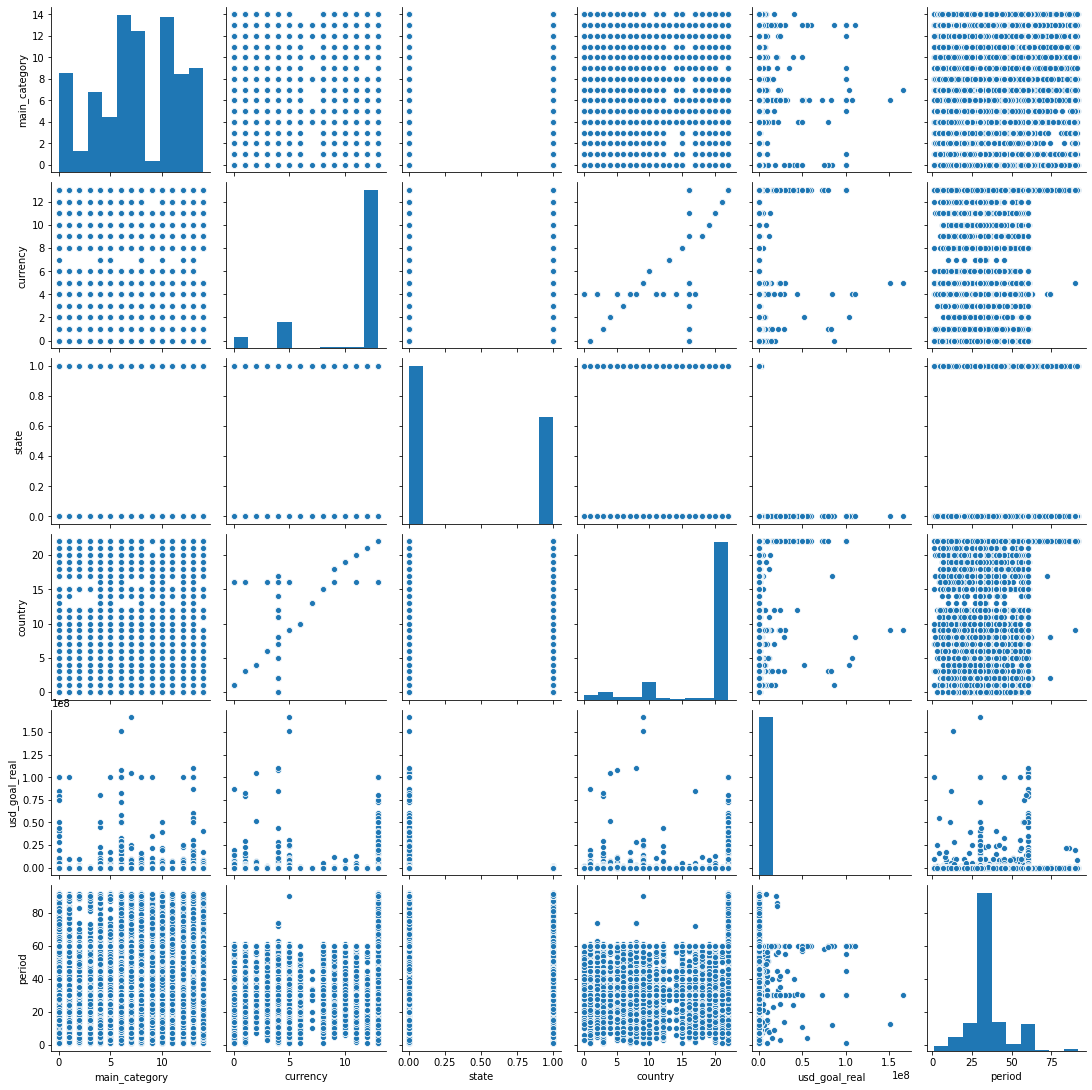

In [10]:
#グラフ化
sns.pairplot(df)

In [11]:
#相関行列
df.corr()

,main_category,currency,state,country,usd_goal_real,period
main_category,1.000000,-0.011872,-0.032147,-0.010828,0.000886,0.038525
currency,-0.011872,1.000000,0.059021,0.985873,-0.004494,0.029467
state,-0.032147,0.059021,1.000000,0.054805,-0.023735,-0.116437
country,-0.010828,0.985873,0.054805,1.000000,-0.004214,0.030319
usd_goal_real,0.000886,-0.004494,-0.023735,-0.004214,1.000000,0.021607
period,0.038525,0.029467,-0.116437,0.030319,0.021607,1.000000


・currencyとcountryは相関が強いので、currencyは削除する

**periodの外れ値確認（Day1レビュー）**

(array([  6217.,  16787.,  34404., 194404.,  35162.,   8232.,  32765.,
           702.,    482.,   2520.]),
 array([ 1. , 10.1, 19.2, 28.3, 37.4, 46.5, 55.6, 64.7, 73.8, 82.9, 92. ]),
 <a list of 10 Patch objects>)

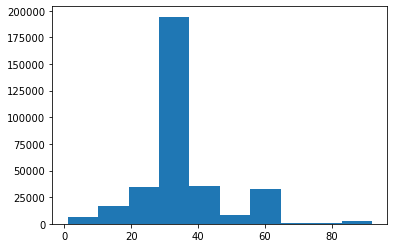

In [12]:
plt.hist(df['period'])

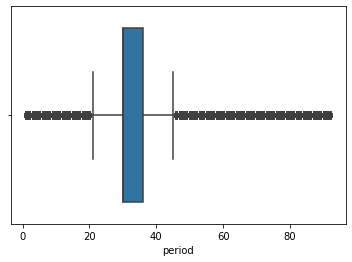

In [13]:
sns.boxplot(df['period'])

In [14]:
period_cut = pd.cut(df['period'],[0,10,20,30,40,50,60,70,80,90,100],right=True).value_counts()
print(period_cut)

(20, 30]     182367
(30, 40]      52565
(50, 60]      34980
(40, 50]      27875
(10, 20]      22847
(0, 10]        6217
(80, 90]       2148
(60, 70]       1617
(70, 80]        592
(90, 100]       467
Name: period, dtype: int64


外れ値にも見えた80付近の値も複数あるので、外れ値はなしと判断。

**usd_goal_realの外れ値確認（Day1レビュー）**

(array([3.31585e+05, 3.70000e+01, 7.00000e+00, 1.50000e+01, 5.00000e+00,
        2.00000e+00, 2.20000e+01, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([1.00000000e-02, 1.66361391e+07, 3.32722782e+07, 4.99084172e+07,
        6.65445563e+07, 8.31806954e+07, 9.98168344e+07, 1.16452974e+08,
        1.33089113e+08, 1.49725252e+08, 1.66361391e+08]),
 <a list of 10 Patch objects>)

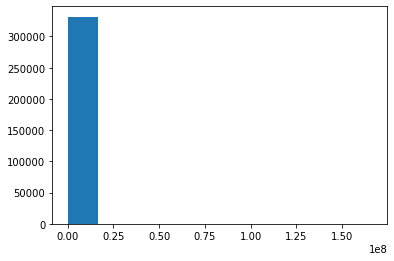

In [15]:
plt.hist(df['usd_goal_real'])

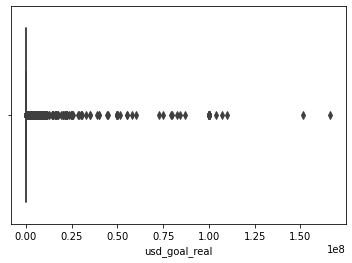

In [16]:
sns.boxplot(df['usd_goal_real'])

In [17]:
usd_cut = pd.cut(df['usd_goal_real'],[0,0.25*10**8,0.50*10**8,0.75*10**8,1*10**8,1.25*10**8,1.5*10**8,1.75*10**8],right=True).value_counts()
print(usd_cut)

(0.0, 25000000.0]             331615
(75000000.0, 100000000.0]         24
(25000000.0, 50000000.0]          24
(50000000.0, 75000000.0]           7
(100000000.0, 125000000.0]         3
(150000000.0, 175000000.0]         2
(125000000.0, 150000000.0]         0
Name: usd_goal_real, dtype: int64


In [18]:
df['usd_goal_real'].describe()

count    3.316750e+05
mean     4.151000e+04
std      1.108930e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

→0.25×10^8以上のデータは複数あるが、それ以下のデータ数と桁が違うので、削除する

In [19]:
df = df[df['usd_goal_real']<25000000]

(array([3.3126e+05, 1.5400e+02, 9.2000e+01, 2.3000e+01, 4.3000e+01,
        5.0000e+00, 9.0000e+00, 3.0000e+00, 1.4000e+01, 6.0000e+00]),
 array([1.00000000e-02, 2.46616728e+06, 4.93233454e+06, 7.39850181e+06,
        9.86466908e+06, 1.23308363e+07, 1.47970036e+07, 1.72631709e+07,
        1.97293381e+07, 2.21955054e+07, 2.46616727e+07]),
 <a list of 10 Patch objects>)

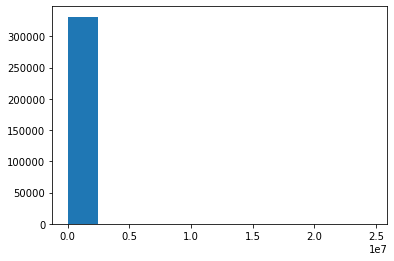

In [20]:
plt.hist(df['usd_goal_real'])

(array([2.74698e+05, 2.80080e+04, 1.20140e+04, 4.39700e+03, 4.05600e+03,
        1.02200e+03, 1.48700e+03, 5.16000e+02, 8.85000e+02, 2.36000e+02]),
 array([1.00000000e-02, 2.49850090e+04, 4.99700080e+04, 7.49550070e+04,
        9.99400060e+04, 1.24925005e+05, 1.49910004e+05, 1.74895003e+05,
        1.99880002e+05, 2.24865001e+05, 2.49850000e+05]),
 <a list of 10 Patch objects>)

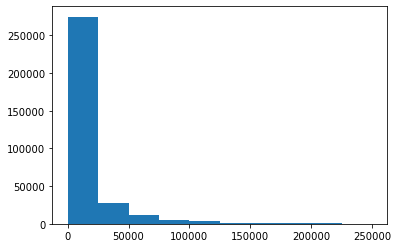

In [21]:
# 結果が変わらないのでさらに2桁減らすこととする
df = df[df['usd_goal_real']<250000]
plt.hist(df['usd_goal_real'])

## ホールドアウト法

データを学習用とテスト用に分け、テスト用データで学習済みモデルの汎化誤差を評価する

In [22]:
# X, yの定義
y = df['state'].values
X = df.drop('state',axis=1).values

In [23]:
# 全データのうち、20%をテスト用データとする
test_size = 0.2
# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

学習用データ：fit_transform  
訓練データ：transform  
  
**訓練誤差を求める**

In [24]:
# 学習用データを標準化する
std_scaler = StandardScaler() 
# fit_transform関数で標準化した学習データX_trainを得る
X_train= std_scaler.fit_transform(X_train)

In [25]:
print(df.columns.values)

['main_category' 'currency' 'state' 'country' 'usd_goal_real' 'period']


(array([2.19603e+05, 2.25260e+04, 9.65400e+03, 3.55500e+03, 3.22600e+03,
        7.97000e+02, 1.19500e+03, 4.14000e+02, 7.00000e+02, 1.85000e+02]),
 array([-0.55942924,  0.41921881,  1.39786686,  2.37651491,  3.35516295,
         4.333811  ,  5.31245905,  6.29110709,  7.26975514,  8.24840319,
         9.22705123]),
 <a list of 10 Patch objects>)

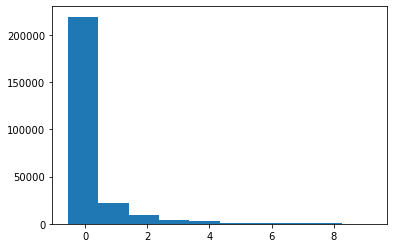

In [26]:
plt.hist(X_train[:,3])
# 標準化できているか、念のためusd_goal_realで確認
# 上記でcurrencyは削除したので、usd_goal_realは3列目

In [27]:
# モデルを作成、学習（ロジスティクス回帰）
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234,  tol=1e-3)
clf.fit(X_train, y_train)

# 重みを取得
w0 = clf.intercept_[0]
w1 = clf.coef_[0,0]
w2 = clf.coef_[0,1]
w3 = clf.coef_[0,2]
w4 = clf.coef_[0,3]
w5 = clf.coef_[0,4]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}'.format(w0, w1, w2, w3, w4, w5))

w0 = -0.416, w1 = -0.114, w2 = 0.396, w3 = -0.199, w4 = -0.613, w5 = -0.196


In [28]:
# ラベルを予測
y_pred = clf.predict(X_train)

print("学習データ（訓練誤差）")

# 正答率を計算
accuracy =  accuracy_score(y_train, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))


学習データ（訓練誤差）
正答率（Accuracy） = 60.070%
適合率（Precision） = 52.005%
再現率（Recall） = 30.970%
F1値（F1-score） = 38.821%


・Day1よりも下がった（Dayとの違いは、usd_goal_realの外れ値を除いたこと、ホールドアウト法を用いたこと）

**汎化誤差を求める**

In [29]:
# transform関数で標準化した学習データX_testを得る（fitしない）
X_test= std_scaler.transform(X_test)

# モデルを作成、学習（ロジスティクス回帰）
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234,  tol=1e-3)
clf.fit(X_test, y_test)

# 重みを取得
w0 = clf.intercept_[0]
w1 = clf.coef_[0,0]
w2 = clf.coef_[0,1]
w3 = clf.coef_[0,2]
w4 = clf.coef_[0,3]
w5 = clf.coef_[0,4]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}'.format(w0, w1, w2, w3, w4, w5))

# ラベルを予測
y_pred = clf.predict(X_test)

print("テスト用データ（汎化誤差）")

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

w0 = -0.396, w1 = -0.054, w2 = 0.375, w3 = -0.235, w4 = -0.404, w5 = -0.185
テスト用データ（汎化誤差）
正答率（Accuracy） = 60.783%
適合率（Precision） = 56.375%
再現率（Recall） = 15.761%
F1値（F1-score） = 24.635%


→わずかに上がった（この程度であれば過学習とは言わない？）

## 交差検証（クロスバリデーション）法

In [33]:
# X, yの定義
y = df['state'].values
X = df.drop('state',axis=1).values

# グループ数を設定（今回は5分割）
n_split = 5

# 各予測精度の初期値をゼロにする
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    
    #学習用データ
    X_train, y_train = X[train_idx], y[train_idx]
    #テスト用データ
    X_test, y_test = X[test_idx], y[test_idx]     
    
    #学習用データのみ標準化
    std_scaler = StandardScaler() 
    X_train= std_scaler.fit_transform(X_train)
    X_test= std_scaler.fit_transform(X_test)
    

    #学習用データを使ってロジスティック回帰モデル作成
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234,  tol=1e-3)
    clf.fit(X_train, y_train)
    
    
    # テストデータのラベルを予測
    y_pred = clf.predict(X_test)
    
    # 予測精度を計算
    accuracy =  accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

    # Precision, Recall, F1-scoreを表示
    print("Fold %s"%split_num)
    print('  正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    print('  適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
    print('  再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
    print('  F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))
    print()

    # スコア平均を求める
    cross_valid_accuracy += accuracy
    cross_valid_precision += precision[1]
    cross_valid_recall += recall[1]
    cross_valid_f1_score += f1_score[1]
    
    split_num += 1

print("交差検証結果")
print('正答率（Accuracy） = {:.3f}%'.format(100 * cross_valid_accuracy / n_split))
print('適合率（Precision） = {:.3f}%'.format(100 * cross_valid_precision / n_split))
print('再現率（Recall） = {:.3f}%'.format(100 * cross_valid_recall / n_split))
print('F1値（F1-score） = {:.3f}%'.format(100 * cross_valid_f1_score / n_split))

Fold 1
  正答率（Accuracy） = 60.558%
  適合率（Precision） = 52.201%
  再現率（Recall） = 35.722%
  F1値（F1-score） = 42.417%

Fold 2
  正答率（Accuracy） = 61.035%
  適合率（Precision） = 55.259%
  再現率（Recall） = 25.942%
  F1値（F1-score） = 35.308%

Fold 3
  正答率（Accuracy） = 59.837%
  適合率（Precision） = 50.763%
  再現率（Recall） = 44.461%
  F1値（F1-score） = 47.403%

Fold 4
  正答率（Accuracy） = 59.802%
  適合率（Precision） = 58.692%
  再現率（Recall） = 6.752%
  F1値（F1-score） = 12.110%

Fold 5
  正答率（Accuracy） = 60.602%
  適合率（Precision） = 54.806%
  再現率（Recall） = 21.139%
  F1値（F1-score） = 30.511%

交差検証結果
正答率（Accuracy） = 60.367%
適合率（Precision） = 54.344%
再現率（Recall） = 26.803%
F1値（F1-score） = 33.550%


## まとめ

**Day1**  
・正答率 = 61.257%  
・適合率（Precision） = 61.683%  
・再現率（Recall） = 92.413%  
・F1値（F1-score） = 73.984%  

**ホールドアウト法で求めた汎化誤差**  
・正答率（Accuracy） = 60.783%  
・適合率（Precision） = 56.375%  
・再現率（Recall） = 15.761%  
・F1値（F1-score） = 24.635%  

**交差検証法で求めた汎化誤差**  
・正答率（Accuracy） = 60.367%  
・適合率（Precision） = 54.344%  
・再現率（Recall） = 26.803%  
・F1値（F1-score） = 33.550%  

## 課題
・正答率が下がってしまったが原因がわからない  
・正しく訓練誤差、汎化誤差を求められているか不安である  
・正則化も試してみたかったが、実装ができなかった  
・データ数が多いためSVMは使用しなかったが、時間があるとき試してみたい